### Scatterplot with color defined by a third list

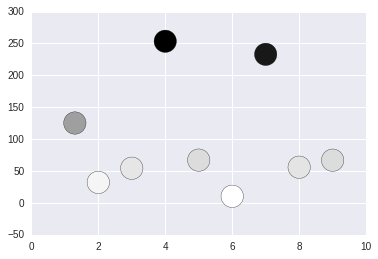

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

x = [1.3, 2, 3, 4, 5, 6, 7, 8, 9]
y = [125.3, 32.23, 54.4, 253.5, 67.1, 10.4, 233, 56, 67]

color = [str(item/255.) for item in y]

plt.scatter(x, y, s=500, c=color)

plt.show()

# NNet classification


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import generate_data
import matplotlib.pyplot as plt
import numpy as np
import theano 
import theano.tensor as T
import pymc3 as pm

X, Y = generate_data.generate_1dlinear_data()
X_train = np.array(np.vstack((X,Y)).T,"float32")
del Y

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
Y_train = np.array( X_train[:,1] >= 3, dtype="float32")

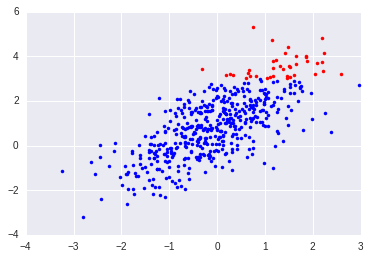

In [5]:
plt.plot(X_train[Y_train==0, 0],X_train[Y_train==0, 1], ".", color="blue")
plt.plot(X_train[Y_train==1, 0],X_train[Y_train==1, 1], ".", color="red")

#### Initialize mlp

- We will model $h(x) = p(y=1 \,\vert\, x)$ using the sigmoid at the output layer

## 1) Fit a model without bias

### Be careful with target as column or row tensor

- This code is the same as the one above with a couple of differences:
    - ann_output is a [500,1] tensor: ``theano.shared(Y_train.reshape((len(Y_train),1)))``
    - init_out has shape (n_hidden, output_dim) instead of (n_hidden)  


In [14]:
n_hidden = 5
input_dim = X_train.shape[1]
output_dim = 1
std_val = 0.5

ann_input = theano.shared(X_train)
Y_train_column = Y_train.reshape((len(Y_train),1))
ann_output = theano.shared(Y_train_column)

n_hidden = 10

# Initialize random weights.
init_1 = np.random.randn(X_train.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)

# If we put output_dim doesn't work
init_out = np.random.randn(n_hidden, output_dim)


neural_network = pm.Model()

with  neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val , 
                             shape=(X_train.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=std_val , 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=std_val , 
                              shape=(n_hidden,output_dim), 
                              testval=init_out)
    
    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

In [15]:
with neural_network:    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)

 [-----------------100%-----------------] 10000 of 10000 complete in 23.6 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ad862af10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7acd38bd10>]], dtype=object)

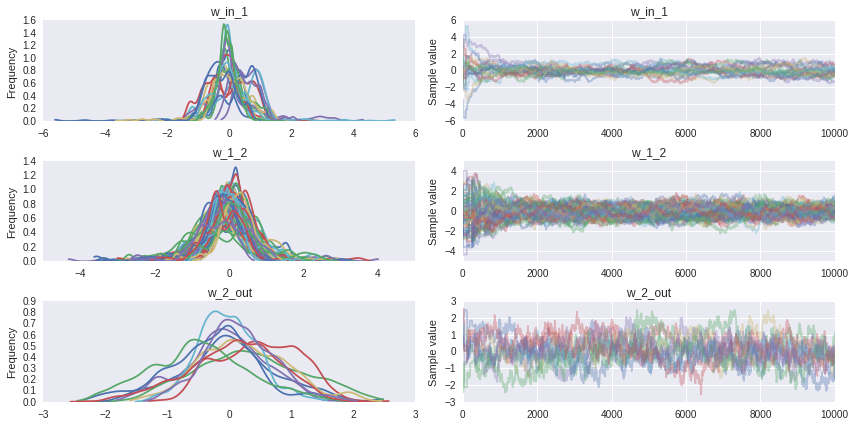

In [16]:
pm.traceplot(trace)

#### Predict train data with target as column: 
#### Won't work because Bernoulli doesn't want data as columns

In [ ]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_train)
ann_output.set_value(Y_train_column)

# Creater posterior predictive samples

########################################################
# Output Bernoulli doesn't like target data in columns #
########################################################

#ppc = pm.sample_ppc(trace,
#                    model=neural_network, 
#                    samples=2000)

In [ ]:
#Y_train_pred = ppc['out'].mean(axis=0) > 0.5
#print('Accuracy = {}%'.format((Y_train == Y_train_pred).mean() * 100))

In [ ]:
#plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
#plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
#plt.title('Predicted labels by trained model')

## NO bias row target vector (500,)

In [18]:
n_hidden = 5
input_dim = X_train.shape[1]
output_dim = 1
std_val = 0.5

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 10

# Initialize random weights.
init_1 = np.random.randn(X_train.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

with pm.Model() as neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val , 
                             shape=(X_train.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=std_val , 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=std_val , 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)


In [19]:
with neural_network:    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)

 [-----------------100%-----------------] 10000 of 10000 complete in 27.0 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7acc6b90d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7ac19181d0>]], dtype=object)

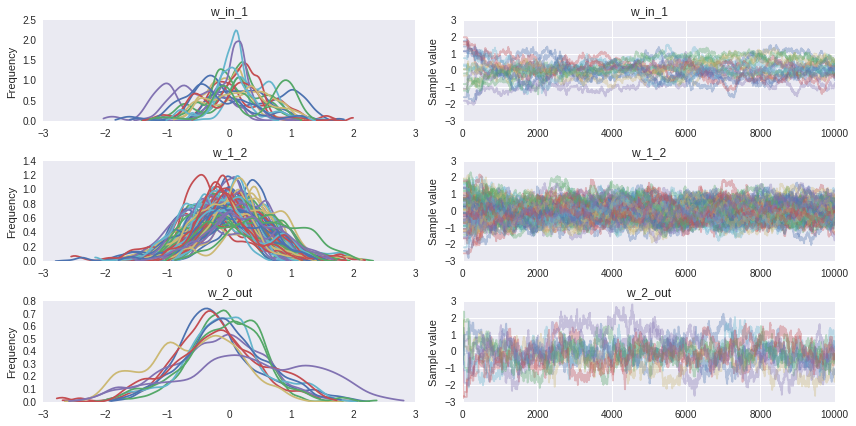

In [20]:
pm.traceplot(trace)

### predict train data

In [89]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace,
                    model=neural_network, 
                    samples=2000)

In [90]:
Y_train_pred = ppc['out'].mean(axis=0) > 0.8
print('Accuracy = {}%'.format((Y_train == Y_train_pred).mean() * 100))

/home/david/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


AttributeError: 'bool' object has no attribute 'mean'

In [ ]:
plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
plt.title('Predicted labels by trained model')

#### Probability regions

- Matplotlib scatterplot; colour as a function of a third variable: http://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable

In [24]:
h = 0.2

#x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
#x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

x1_min, x1_max = -4, 4
x2_min, x2_max = -4, 4

x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, h),
                               np.arange(x2_min, x2_max, h))

grid_2d = np.array(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype="float32")

In [25]:
grid_2d.shape

(1600, 2)

In [26]:
dummy_out = np.ones(grid_2d.shape[1], dtype=np.int8)

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

ppc = pm.sample_ppc(trace,
                    model=neural_network, 
                    samples=2000)

In [27]:
ppc['out'].shape

(2000, 1600)

In [28]:
ppc['out'].mean(axis=0).shape

(1600,)

In [29]:
predictions = ppc['out'].mean(axis=0)

In [30]:
width = np.sqrt(1600)
width

40.0

In [31]:
X_train.shape

(500, 2)

In [32]:
predictions.reshape((40,40))

array([[ 0.2885,  0.292 ,  0.322 , ...,  0.931 ,  0.9375,  0.9325],
       [ 0.3   ,  0.277 ,  0.2985, ...,  0.927 ,  0.9325,  0.92  ],
       [ 0.2895,  0.3085,  0.3035, ...,  0.936 ,  0.936 ,  0.9275],
       ..., 
       [ 0.0735,  0.069 ,  0.0795, ...,  0.679 ,  0.709 ,  0.717 ],
       [ 0.068 ,  0.0645,  0.0675, ...,  0.6855,  0.682 ,  0.69  ],
       [ 0.074 ,  0.064 ,  0.0735, ...,  0.7175,  0.6975,  0.6955]])

In [33]:
grid_2d.shape, predictions.shape

((1600, 2), (1600,))

In [34]:
max(predictions*100)

95.25

In [35]:
colors = np.array([p for p in predictions])


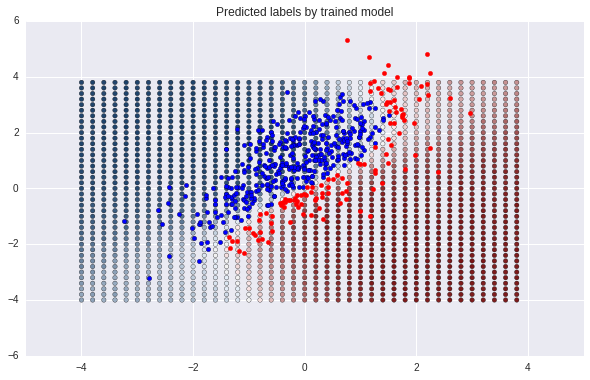

In [36]:
import seaborn as sns
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

colors = np.array([p for p in predictions])

plt.scatter(grid_2d[:,0],
            grid_2d[:,1], 
            c =colors,
            cmap =cmap)

plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
plt.title('Predicted labels by trained model')

#### Decision boundary using contour: TODO

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [ ]:
grid = np.mgrid[-4:4:200j, -4:4:200j]
grid_2d = np.array(grid.reshape(2, -1).T, dtype="float32")
X, Y = grid
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=1000)

In [ ]:
ppc['out'].mean(axis=0).shape

## 2) Fit a model with bias

In [37]:
#####################################
# SHAPES OF THE MODEL WITHOUT BIAS
#####################################

init_1 = np.random.randn(X_train.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

print("\nweight initialization shapes of the layers in  MLP without bias:\n")
print("init_w1 shape:", init_1.shape)
print("init_w2 shape:", init_2.shape)
print("init_w3 shape:", init_out.shape)


weight initialization shapes of the layers in  MLP without bias:

('init_w1 shape:', (2, 10))
('init_w2 shape:', (10, 10))
('init_w3 shape:', (10,))


In [38]:
n_hidden = 5
input_dim = X_train.shape[1]
output_dim = 1
std_val = 0.5

ann_input = theano.shared( np.array(X_train, "float32"))
ann_output = theano.shared( np.array(Y_train, "float32"))

# Initialize random weights between each layer
init_w1 = np.random.randn(X_train.shape[1] , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden,)
init_b2 = np.random.randn(output_dim)

In [39]:

print("\nweight initialization shapes of the layers in  MLP without bias:\n")
print("init_w1 shape:", init_w1.shape)
print("init_b1 shape:", init_b1.shape)
print("init_w2 shape:", init_w2.shape)
print("init_b2 shape:", init_b2.shape)


weight initialization shapes of the layers in  MLP without bias:

('init_w1 shape:', (2, 5))
('init_b1 shape:', (5,))
('init_w2 shape:', (5,))
('init_b2 shape:', (1,))


In [101]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

mlp_bias = pymc3.Model()


# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden )
#init_b2 = np.random.randn(output_dim)

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

with mlp_bias:
    
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    w_in_1 = pm.Normal('w_in_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    b_1 =  pm.Normal('b_1', 0, sd=std_val, 
                           shape= (n_hidden), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    w_1_out = pm.Normal('w_1_out', 0, sd=std_val, 
                              shape=(n_hidden ), 
                              testval=init_w2)
    
    #bias_out=  pm.Normal('bias_out', 0, sd=std_val, 
    #                       shape= (output_dim), 
    #                       testval=init_b2)
        
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.tanh(T.dot(ann_input, w_in_1 ) + b_1)
    act_out = T.nnet.sigmoid(T.dot(act_1, w_1_out))
   
    #act_out = T.nnet.sigmoid(T.dot(act_1, w_1_out) + b_out)
  
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

In [41]:
with mlp_bias:    
    step = pm.Metropolis()
    trace_bias = pm.sample(5000, step=step)

 [-----------------100%-----------------] 5000 of 5000 complete in 6.7 sec

### predict train data

In [91]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Creater posterior predictive samples
ppc_bias = pm.sample_ppc(trace_bias,
                    model=mlp_bias, 
                    samples=1000)

In [98]:
Y_train_pred = ppc_bias['out'].mean(axis=0) > 0.5
print('Accuracy = {}%'.format((Y_train == Y_train_pred).mean() * 100))

Accuracy = 98.6%


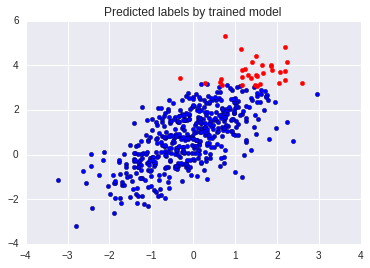

In [99]:
plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
plt.title('Predicted labels by trained model')

### Plot probability regions

Plotting the decision boundary

- http://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot

- https://www.quora.com/How-do-I-plot-the-decision-boundary-for-a-neural-network-classifier-in-MATLAB



In [76]:
h = 0.2
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, h),
                               np.arange(x2_min, x2_max, h))

grid = np.array(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype="float32")

In [77]:

x1_min, x1_max = -4, 4
x2_min, x2_max = -4, 4

x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, h),
                               np.arange(x2_min, x2_max, h))

grid_2d = np.array(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype="float32")

In [81]:
dummy_out = np.ones(grid_2d.shape[1], dtype=np.int8)

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

ppc_bias = pm.sample_ppc(trace_bias,
                         model=mlp_bias, 
                         samples=2000)

predictions_bias = ppc_bias['out'].mean(axis=0)

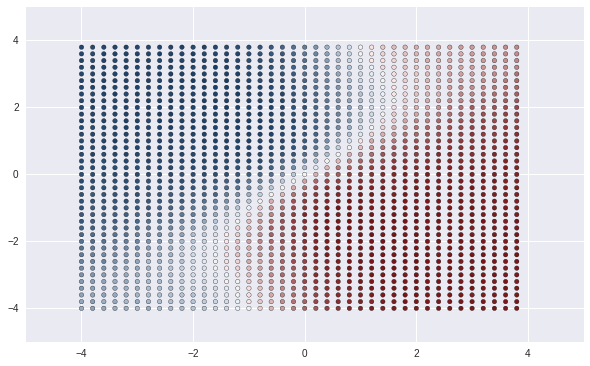

In [87]:
import seaborn as sns
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

colors = np.array([p for p in predictions])

plt.scatter(grid_2d[:,0],
            grid_2d[:,1], 
            c =colors,
            cmap =cmap)

#plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
#plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
#plt.title('Predicted labels by trained model')

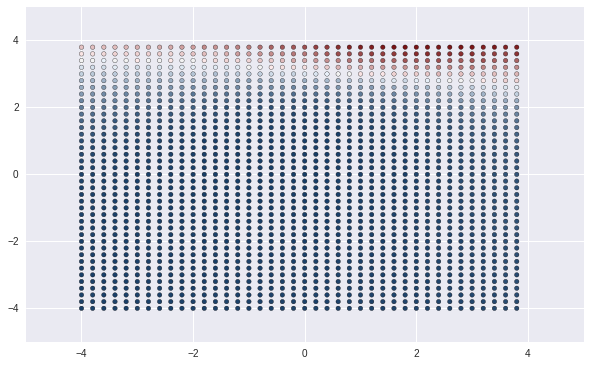

In [86]:
import seaborn as sns
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

colors = np.array([p for p in predictions])

plt.scatter(grid_2d[:,0],
            grid_2d[:,1], 
            c =colors,
            cmap =cmap)

#plt.scatter(X_train[Y_train_pred==0, 0], X_train[Y_train_pred==0, 1])
#plt.scatter(X_train[Y_train_pred==1, 0], X_train[Y_train_pred==1, 1], color='r')
#plt.title('Predicted labels by trained model')